In [1]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=3

In [2]:
!ls

sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/MonaCoBERT/src

/content/drive/MyDrive/Colab Notebooks/MonaCoBERT/src


# Before you run this code... 

To run this code, you have to change two things from  **`src/get_modules/get_models.py`** file. 
1. append `from models.monacobert_ctt_viz import MonaCoBERT_CTT_VIZ` on the 1st line.
2. change 25th line : 
  ```
  elif config.model_name == "monacobert_ctt":
          model = MonaCoBERT_CTT(...
  ```
  to 

  ```
  elif config.model_name == "monacobert_ctt":
          model = MonaCoBERT_CTT_VIZ(...
  ```


In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from get_modules.get_loaders import get_loaders
from get_modules.get_models import get_models
from get_modules.get_trainers import get_trainers
from utils import get_optimizers, get_crits, recorder, visualizer
from scipy.special import softmax

device = "cuda" if torch.cuda.is_available() else "cpu"

# load model ...
model_dict = torch.load("../param/0.8089741885505527_8_29_13_28_ctt_model.pth", map_location=device)
print(model_dict)
setattr(model_dict['config'], 'fivefold', False)
config = model_dict['config']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
idx = 0
train_loader, valid_loader, test_loader, num_q, num_r, num_pid, num_diff = get_loaders(config, idx)
del train_loader
del valid_loader

# 2. select models using get_models
model = get_models(num_q, num_r, num_pid, num_diff, device, config)
# 3. select optimizers using get_optimizers
optimizer = get_optimizers(model, config)
# 4. select crits using get_crits
crit = get_crits(config)
model.load_state_dict(model_dict['model'])
# 5. select trainers for models, using get_trainers
trainer = get_trainers(model, optimizer, device, num_q, crit, config)
# 6. use trainer.train to train the models
if config.crit == "binary_cross_entropy":
    best_test_score = 0
    metric_name = "AUC"
elif config.crit == "rmse":
    best_test_score = float('inf')
    metric_name = "RMSE"

# train test_loader
test_score = trainer._test(test_loader, metric_name)
if config.crit == "binary_cross_entropy":
    if test_score >= best_test_score:
        best_test_score = test_score
elif config.crit == "rmse":
    if test_score <= best_test_score:
        best_test_score = test_score

print("result: test_score=%.4f best_test_score=%.4f" % (
    test_score,
    best_test_score,
))

In [7]:
epoch = 0
attnviz_df = pd.DataFrame(columns=range(149),index=range(149))

for data in test_loader : #epoch
    for bs in range(len(data[epoch])) : # batch size
        if data[epoch][bs].max() > 148 : continue
        if data[epoch][bs].dtype == torch.bool : continue
            # data[epoch][bs] = torch.gt(data[epoch][bs], 0).float()
        seq  = data[epoch][bs].tolist()

        for head_num in range(8) :
            if head_num==0 : head_avg = model.encoder[11].attn_scores[epoch][bs][head_num]
            else : head_avg = torch.add(model.encoder[11].attn_scores[epoch][bs][head_num],head_avg)
        # print(torch.sum(head_avg,axis=1))
        head_avg = head_avg.div(8)

        avgattn_df = pd.DataFrame(head_avg.numpy(), index=seq , columns=seq).transpose()
        # print(avgattn_df)
        drop_idx = avgattn_df[avgattn_df.sum(axis=1)==0].index
        avgattn_df.drop(index=drop_idx,inplace=True)
        avgattn_df = avgattn_df.transpose()
        avgattn_df.drop(index=drop_idx,inplace=True)
        avgattn_df = avgattn_df.transpose()

        # if data[epoch][bs].min() == 0 : avgattn_df.drop(index=0,columns=0,inplace=True)
        
        temp_df = pd.DataFrame()
        for col_name in list(set(avgattn_df.columns.to_list())) :
            if len(avgattn_df[col_name].shape) > 1 : temp_df[col_name] = avgattn_df[col_name].sum(axis=1).div(avgattn_df[col_name].shape[1])
            else : temp_df[col_name] = avgattn_df[col_name]

        temp_df = temp_df.transpose()
        result_df = pd.DataFrame()
        for col_name in list(set(temp_df.columns.to_list())) :
            if len(temp_df[col_name].shape) > 1 : result_df[col_name] = temp_df[col_name].sum(axis=1).div(temp_df[col_name].shape[1])
            else : result_df[col_name] = temp_df[col_name]

        result_np = result_df.to_numpy()
        if (result_np.size > 0) : 
            result_softmax = softmax(result_np,axis=1)
            softmax_df = pd.DataFrame(result_softmax,index=result_df.index,columns=result_df.columns.values)
            
            for col in softmax_df.columns :
                for idx in softmax_df.index :
                    if np.isnan(attnviz_df[col][idx]) : attnviz_df[col][idx] = softmax_df[col][idx]
                    else : 
                        attnviz_df[col][idx] = (softmax_df[col][idx] + attnviz_df[col][idx]) / 2       
        
    epoch += 1

# visualization
attnviz_df = attnviz_df.fillna(0)
attnviz_df.to_csv("attn_result.csv")

In [8]:
attnviz_df

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.019687,0.0,0,0.000000,0.000000,0.018511,0.018107,0.0,0.018958,0.01861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
1,0.000000,1.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
2,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,0.000000,0.0,0,0.049148,0.112780,0.000000,0.000000,0.0,0.000000,0.01786,...,0.000000,0.000000,0.000000,0.105061,0.000000,0.111332,0.000000,0,0.000000,0.000000
4,0.000000,0.0,0,0.112338,0.276518,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.098372,0.099830,0.000000,0.108682,0.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.0,0,0.112243,0.110616,0.000000,0.000000,0.0,0.000000,0.00000,...,0.118361,0.050027,0.062492,0.113292,0.068496,0.221075,0.049425,0,0.000000,0.073508
145,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.050345,0.049530,0.049562,0.049714,0.049545,0.049569,0,0.000000,0.000000
146,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
147,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.482273,0.517342


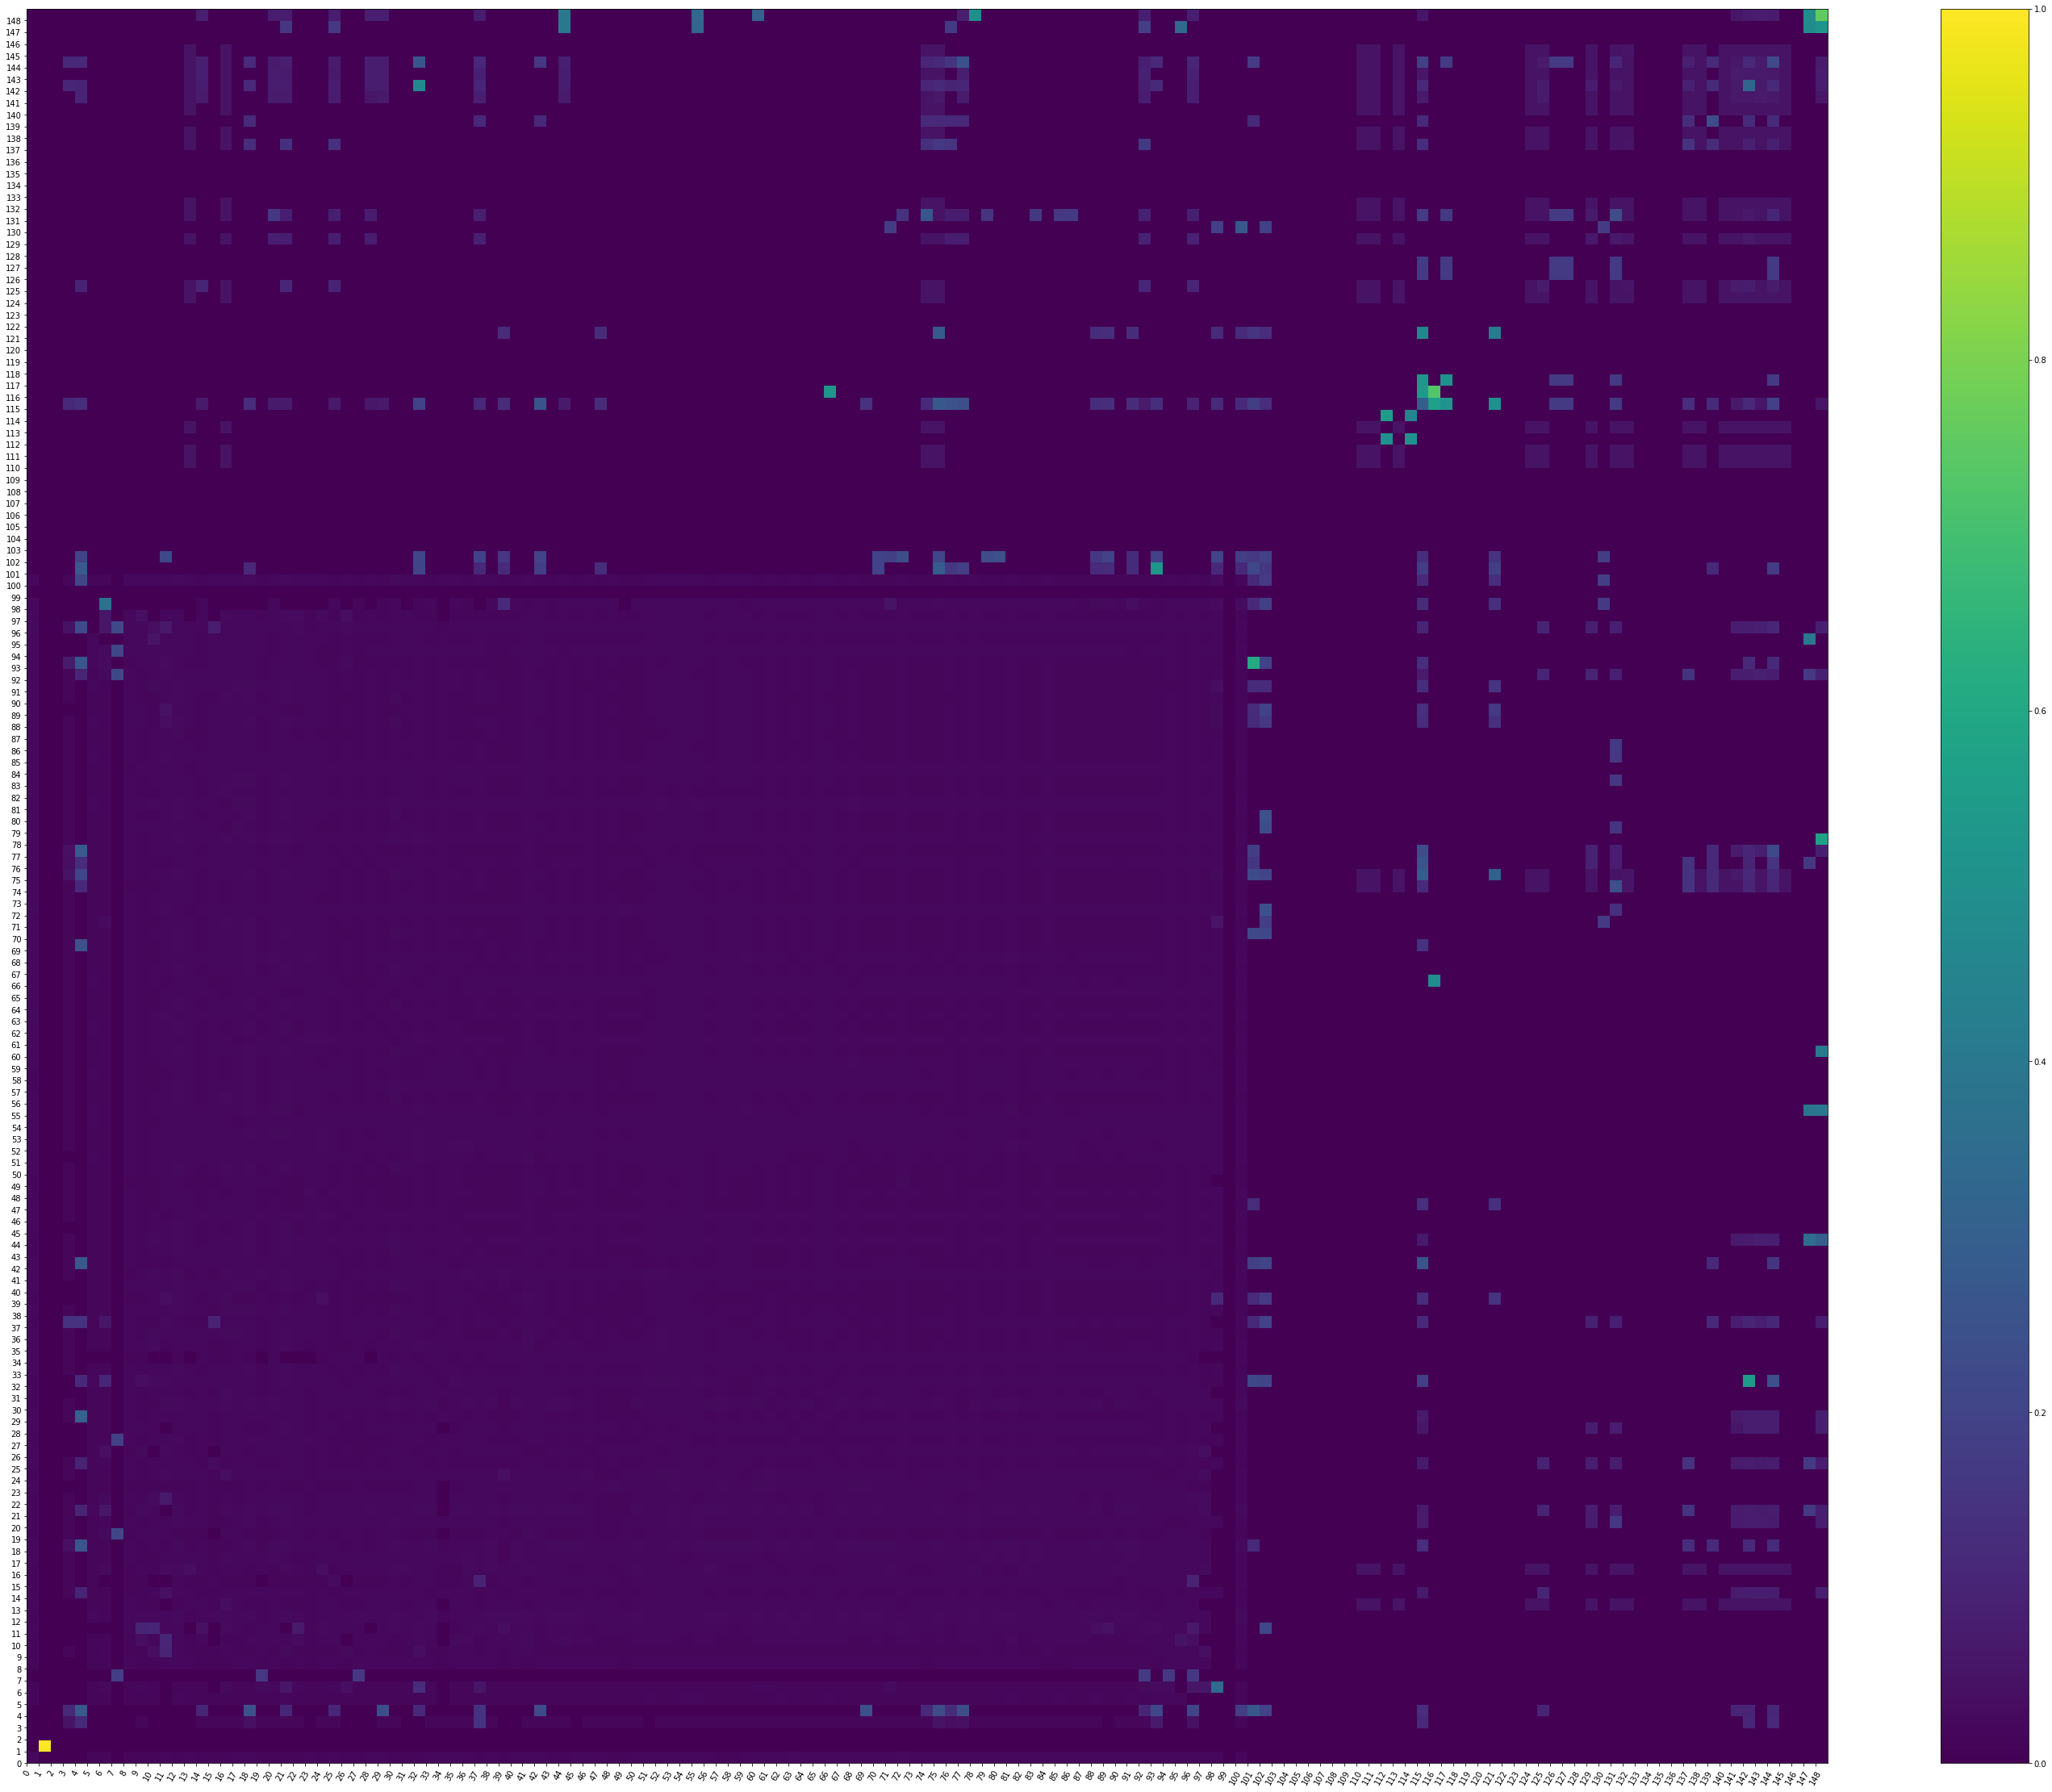

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50,40))
fig.set_facecolor('white')
 
plt.pcolor(attnviz_df.values)
plt.xticks(range(len(attnviz_df.columns)),attnviz_df.columns) ## x축 눈금 생성
plt.yticks(range(len(attnviz_df.index)), attnviz_df.index) ## y축 눈금 생성
plt.xticks(rotation=60)

plt.colorbar()
plt.savefig('heatmap_with_monotonicattn.png')
plt.show()

In [4]:
import numpy as np
import pandas as pd

In [5]:
attnviz_df = pd.read_csv("attn_result.csv")
attnviz_df.drop(columns='Unnamed: 0',inplace=True);attnviz_df

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.019687,0.0,0,0.000000,0.000000,0.018511,0.018107,0.0,0.018958,0.01861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
1,0.000000,1.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
2,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,0.000000,0.0,0,0.049148,0.112780,0.000000,0.000000,0.0,0.000000,0.01786,...,0.000000,0.000000,0.000000,0.105061,0.000000,0.111332,0.000000,0,0.000000,0.000000
4,0.000000,0.0,0,0.112338,0.276518,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.098372,0.099830,0.000000,0.108682,0.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.0,0,0.112243,0.110616,0.000000,0.000000,0.0,0.000000,0.00000,...,0.118361,0.050027,0.062492,0.113292,0.068496,0.221075,0.049425,0,0.000000,0.073508
145,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.050345,0.049530,0.049562,0.049714,0.049545,0.049569,0,0.000000,0.000000
146,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
147,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.482273,0.517342


In [6]:
skill_id_dict = np.load("./skill_id_name_2",allow_pickle='TRUE')
print(skill_id_dict)

{112: 'Circle Graph', 114: 'Circle Graph', 111: 'Circle Graph', 113: 'Circle Graph', 126: 'Median', 123: 'Range', 144: 'Table', 143: 'Table', 93: 'Multiplication and Division Integers', 75: 'Equation Solving Two or Fewer Steps', 74: 'Equation Solving More Than Two Steps', 94: 'Addition and Subtraction Positive Decimals', 6: 'Exponents', 47: 'Number Line', 59: 'Distributive Property', 96: 'Addition and Subtraction Integers', 102: 'Congruence', 28: 'Rounding', 21: 'Multiplication Fractions', 92: 'Addition and Subtraction Fractions', 26: 'Addition Whole Numbers', 29: 'Ordering Integers', 32: 'Ordering Positive Decimals', 77: 'Order of Operations +,-,/,* () positive reals', 49: 'Solving for a variable', 81: 'Surface Area Rectangular Prism', 71: 'Nets of 3D Figures', 39: 'Calculations with Similar Figures', 140: 'Table', 138: 'Table', 115: 'Probability of a Single Event', 141: 'Table', 142: 'Table', 37: 'Conversion of Fraction Decimals Percents', 19: 'Subtraction Whole Numbers', 27: 'Additi

In [7]:
relation_dict = {}
score_dict = {}
for col_name in attnviz_df.columns.to_list() :
    for idx in range(len(attnviz_df)) :
        if attnviz_df[col_name].iloc[idx] > 0.2 :
            if col_name not in relation_dict.keys() : 
                relation_dict[col_name] = [attnviz_df.index[idx]]
                score_dict[col_name] = [attnviz_df[col_name].iloc[idx]]
            else : 
                relation_dict[col_name].append(attnviz_df.index[idx]) 
                score_dict[col_name].append(attnviz_df[col_name].iloc[idx]) 
relation_dict

{'1': [1],
 '4': [4, 18, 29, 42, 69, 75, 77, 93, 96, 100, 101, 102],
 '6': [98],
 '7': [19, 92, 94, 96],
 '11': [102],
 '18': [4],
 '29': [4],
 '32': [101, 102, 142, 144],
 '42': [4, 102, 115],
 '44': [147, 148],
 '55': [147, 148],
 '60': [148],
 '66': [116],
 '69': [4],
 '72': [102],
 '74': [131],
 '75': [4, 101, 102, 115, 121],
 '76': [115],
 '77': [4, 115, 144],
 '78': [148],
 '79': [102],
 '80': [102],
 '93': [4, 101],
 '95': [147],
 '98': [6, 102],
 '100': [130],
 '101': [4, 32, 70, 75, 93, 101],
 '102': [11, 32, 42, 70, 72, 75, 79, 80],
 '112': [112, 114],
 '114': [112, 114],
 '115': [42, 75, 76, 77, 115, 116, 117, 121],
 '116': [66, 115, 116],
 '117': [115, 117],
 '121': [75, 115, 121],
 '131': [74, 131],
 '139': [139],
 '142': [32, 142],
 '144': [32, 77, 144],
 '147': [44, 55, 95, 147, 148],
 '148': [44, 55, 60, 78, 147, 148]}

In [8]:
score_dict

{'1': [1.0],
 '4': [0.2765179405723756,
  0.2583072910783812,
  0.3057747185230255,
  0.2728232741355896,
  0.252773754298687,
  0.2062934646382928,
  0.2840008893981576,
  0.2668272219598293,
  0.2234886214137077,
  0.2111497372388839,
  0.2836073935031891,
  0.201760783791542],
 '6': [0.3734217882156372],
 '7': [0.2109675109386444,
  0.2126419693231582,
  0.2102459967136383,
  0.2151805311441421],
 '11': [0.2154415249824524],
 '18': [0.2525141715304926],
 '29': [0.2385964393615722],
 '32': [0.2050965577363968,
  0.2050847262144088,
  0.4719243049621582,
  0.2684796452522278],
 '42': [0.2255827188491821, 0.2023932039737701, 0.2546879313886165],
 '44': [0.4061555778607726, 0.3951370675931684],
 '55': [0.3272864520549774, 0.3326812386512756],
 '60': [0.3051840364933014],
 '66': [0.5198075175285339],
 '69': [0.244076631963253],
 '72': [0.2333502471446991],
 '74': [0.2682425454258919],
 '75': [0.2286838237196207,
  0.2860510498285293,
  0.2077466994524002,
  0.2696291499523795,
  0.280371

In [9]:
attnviz_df.iloc[148]

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
144    0.073847
145    0.000000
146    0.000000
147    0.489760
148    0.754969
Name: 148, Length: 149, dtype: float64

In [10]:
add_list = []
for col_name in attnviz_df.columns.to_list() :
    for idx in attnviz_df.index.to_list() :
        if attnviz_df[col_name][idx] > 0.1 :
            add_list.append((idx,int(col_name),attnviz_df[col_name][idx]))
graph_df = pd.DataFrame(add_list, columns = ['source', 'target', 'weight']);graph_df

,source,target,weight
0,1,1,1.000000
1,4,3,0.112338
2,37,3,0.144230
3,115,3,0.112591
4,142,3,0.106049
...,...,...,...
379,55,148,0.401105
380,60,148,0.405323
381,78,148,0.570260
382,147,148,0.517342


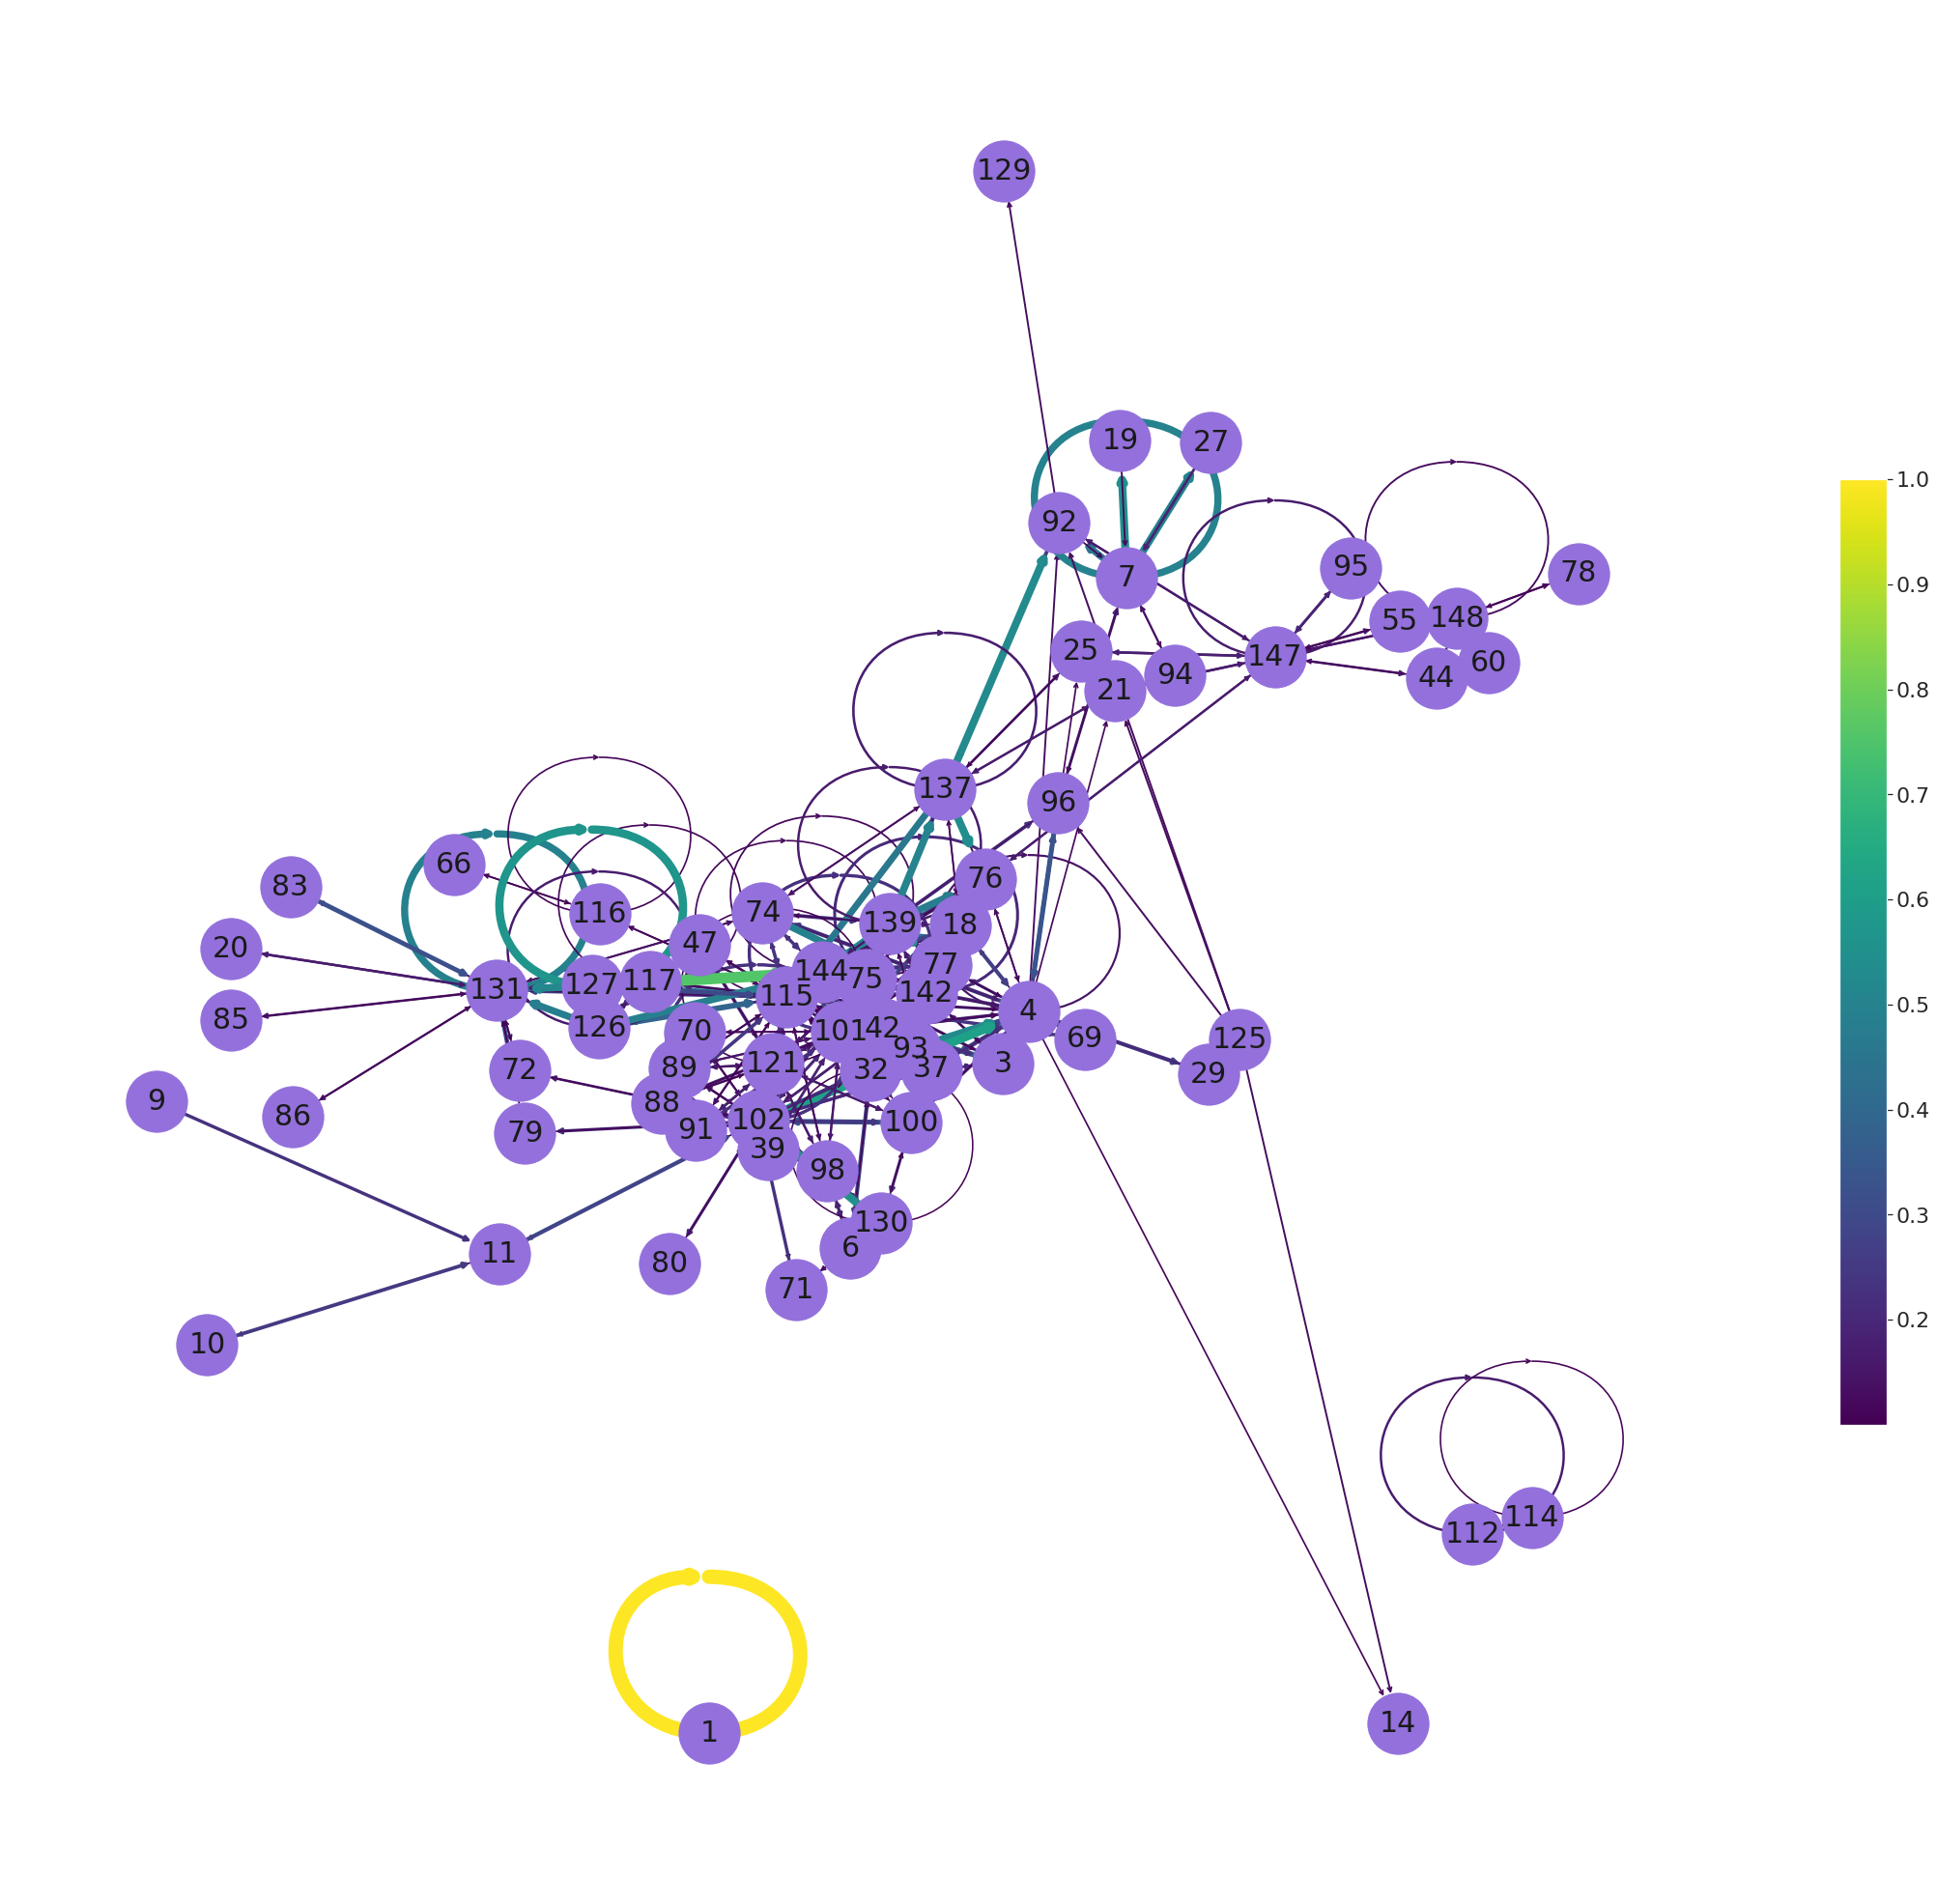

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(40,36)) 

G = nx.from_pandas_edgelist(graph_df, 'source', 'target', ['weight'], create_using = nx.DiGraph)

seed = 100  # Seed random number generators for reproducibility
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G,seed=seed)
# pos = nx.shell_layout(G)

M = G.number_of_edges()
edge_colors = graph_df['weight']
# edge_colors = range(2, M + 2)
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.viridis

nodes = nx.draw_networkx_nodes(G, pos, node_size = 4000, node_color="mediumpurple")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size = 4000,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=graph_df['weight']*15,
)
nx.draw_networkx_labels(G, pos, font_size=30)

# # set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc, shrink=0.5)

ax = plt.gca()
ax.set_axis_off()
plt.savefig('graph_with_monotonicattn.png')
plt.show()

In [12]:
# plt.show()

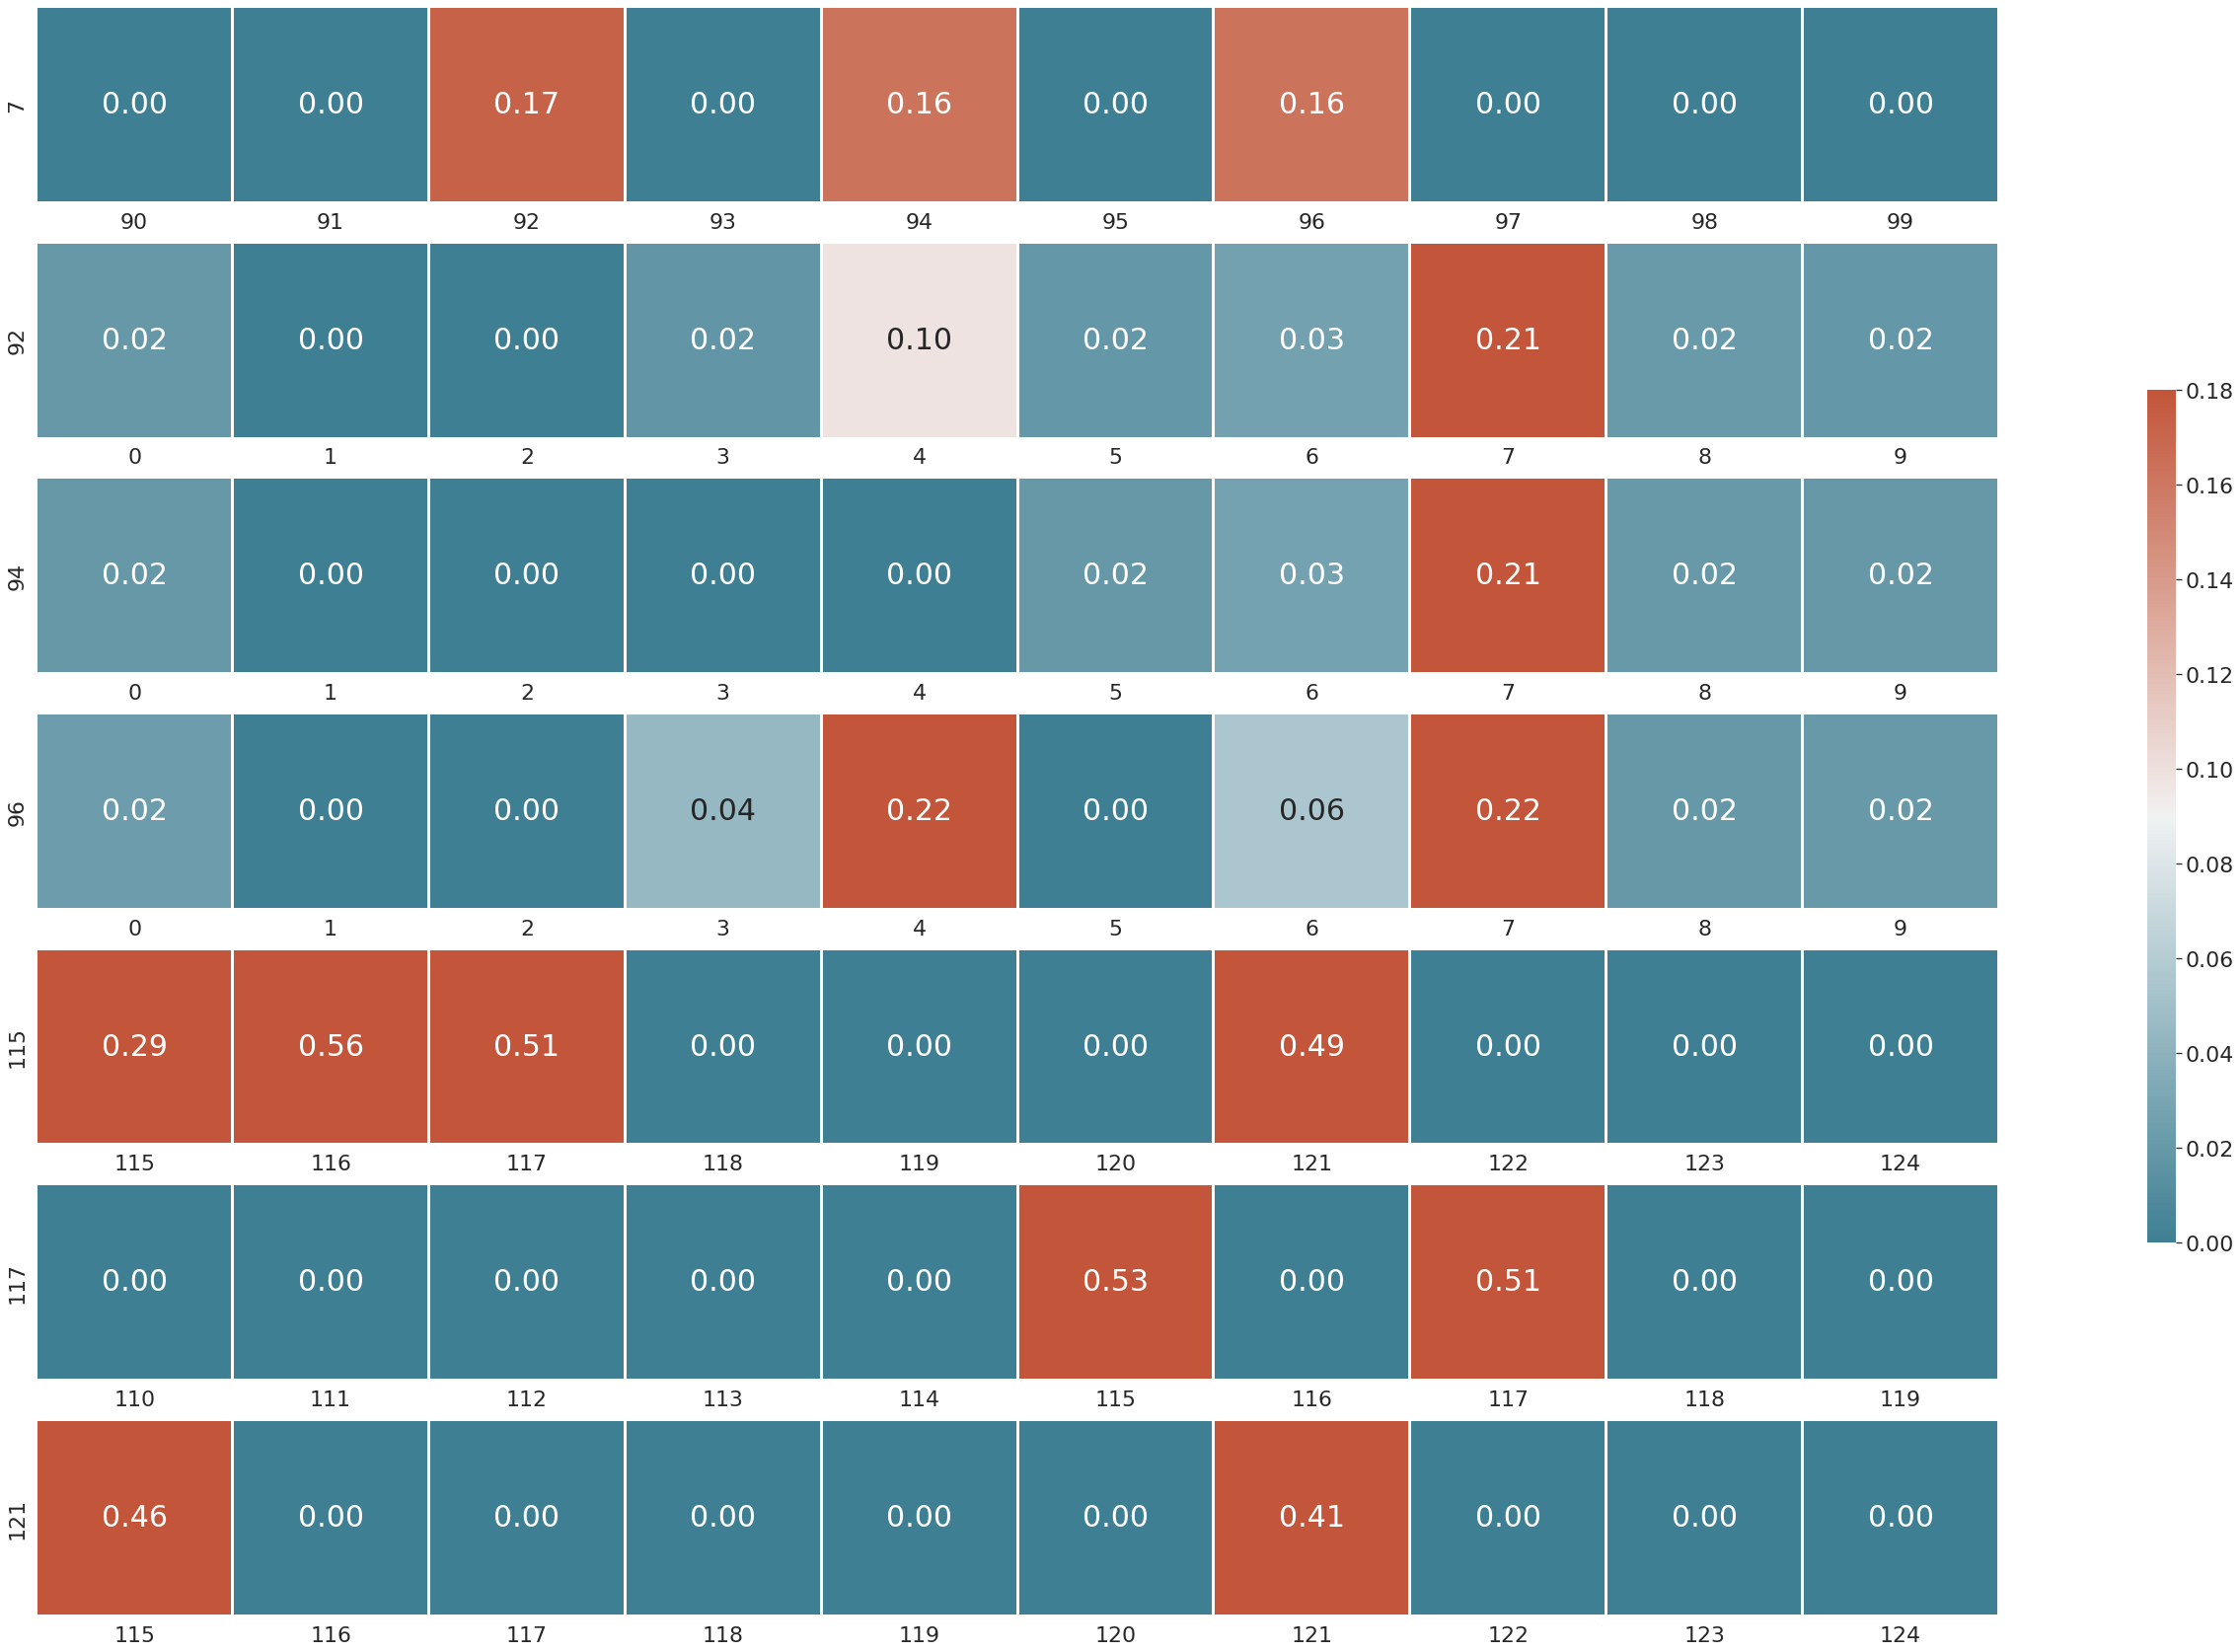

In [31]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


attnviz_df['149'] = np.nan
attn_7 = attnviz_df.iloc[[7],90:100]
attn_92 = attnviz_df.iloc[[92],0:10]
attn_94 = attnviz_df.iloc[[94],0:10]
attn_96 = attnviz_df.iloc[[96],0:10]
attn_115 = attnviz_df.iloc[[115],115:125]
attn_117 = attnviz_df.iloc[[117],110:120]
attn_121 = attnviz_df.iloc[[121],115:125]

fig, ax = plt.subplots(figsize=(40, 30), nrows=7)
cbar_ax = fig.add_axes([.91, .3, .01, .4])
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

vmin = 0
vmax = 0.18
sns.heatmap(attn_7, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[0], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
sns.heatmap(attn_92, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[1], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_94, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[2], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_96, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[3], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_115, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[4], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_117, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[5], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(attn_121, square=True, annot=True,annot_kws={"size": 30}, linewidths=2, ax=ax[6], fmt = '.2f', cmap=cmap, vmin=vmin, vmax=vmax, cbar=False)